In [1]:
from typing import Any, Callable, NamedTuple, Tuple, Union
Step = int
Schedule = Callable[[Step], float]

from IPython import display
from IPython.display import Image, clear_output
from PIL import Image
import glob, os, shutil

import time

import scipy.io as io
import scipy.sparse.csgraph as csgraph
from scipy.sparse.csgraph import laplacian as csgraph_laplacian
import scipy as sp
from scipy.stats import gaussian_kde
from scipy.linalg import null_space

import jax
from jax import jit, vmap, random, grad, value_and_grad, hessian
from jax.experimental import optimizers
from jax.experimental.optimizers import optimizer
from jax import numpy as jnp

from functools import partial
import itertools

import math
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import collections as mc
import seaborn as sns

import datetime
from tqdm.notebook import tqdm

import networkx as nx

%load_ext autoreload
%autoreload 2

In [2]:
import utils
from utils import *
from optimizers import *

In [3]:
# load the data from the SuiteSparse Matrix Collection format
# https://www.cise.ufl.edu/research/sparse/matrices/
graphs = ['qh882','dwt_1005','3elt','commanche_dual','bcsstk31']
graphdir = './testcases/'
graphpostfix = 'qh882'
assert graphpostfix in graphs

G, A, L, D, n = load_graph(graphdir+graphpostfix, plot_adjacency=False, verbose=True)

Name: 
Type: Graph
Number of nodes: 882
Number of edges: 1933
Average degree:   4.3832


In [4]:
del G
del A
del D

In [5]:
@jit
def _step_noautograd(stp, X_k, A_x, A_y, b_x, b_y):
    """Perform a single gradient (using autograd) + projection step with adaptive momentum."""
    E_0 = stp*jnp.vstack([b_x,b_y]).T
    X_k_x = X_k[:,0] - stp*A_x@X_k[:,0]
    X_k_y = X_k[:,1] - stp*A_y@X_k[:,1]
    X_k_t = jnp.vstack([X_k_x,X_k_y]).T - E_0
    X_k_t = project(X_k_t, C, E_0)
    return X_k_t

def pgd(X_k, A_x, A_y, b_x, b_y, C, convergence_criterion, 
           maxiters=1000, alpha=1e-2, beta=0.9):
    """Perform iterations of PGD, without autograd."""
    loss = []
    param_hist  = []
    grad_hist = []
    E_0 = jnp.stack([b_x, b_y], axis=1)
    L = jnp.linalg.inv(C)@X_k.T@(A_x@X_k+E_0)
    Ls = [L]
    
    for k in tqdm(range(maxiters)):
        # backtracking line search
        f_xp = 1e8
        stp = 1

        f_x = f(X_k, A_x, A_y, b_x, b_y)
        X_k_t = X_k
        derphi=1
        while f_xp >= f_x - alpha * stp * derphi:
            stp *= beta
            X_k_t = _step_noautograd(stp, X_k, A_x, A_y, b_x, b_y)    
            f_xp = f(X_k_t, A_x, A_y, b_x, b_y)
        
            if stp < 1e-6:
                break  
        if len(loss) > 1 and np.abs(f_x - loss[-1]) <= convergence_criterion:
            break
        #step_sizes.append(stp)
        X_k = X_k_t
        param_hist.append(X_k)
        loss.append(f_x) 
        L = jnp.linalg.inv(C)@X_k.T@(A_x@X_k+E_0)
        Ls.append(L)
        grad_hist.append(foc_pgd(X_k, L, C, A_x, b_x, b_y))
        
    return {'x':X_k, 'lossh':loss, 'sln_path':param_hist, 'foc':grad_hist, 'ext_data':{'L':Ls}}

@jit
def step(i, opt_state, A_x, A_y, b_x, b_y):
    """Perform a single gradient (using autograd) + projection step with adaptive momentum."""
    p = get_params(opt_state)
    g = grad(f)(p, A_x, A_y, b_x, b_y)
    return opt_update(i, g, opt_state)

def pgd_autograd(opt_params, A_x, A_y, b_x, b_y, C, convergence_criterion, maxiters=1000):
    """Perform iterations of PGD, with autograd """
    opt_state, opt_update, get_params = opt_params
    E_0 = jnp.stack([b_x, b_y], axis=1)
    X_k = get_params(opt_state)
    loss = [f(X_k, A_x, A_y, b_x, b_y)]
    L = jnp.linalg.inv(C)@X_k.T@(A_x@X_k+E_0)
    Lh = [L]
    param_hist  = [X_k]
    grad_hist= [foc_pgd(X_k, L, C, A_x, b_x, b_y)]
    for k in tqdm(range(maxiters)):
        opt_state = step(k, opt_state, A_x, A_y, b_x, b_y)
        X_k = get_params(opt_state)
        param_hist.append(X_k)
        l = f(X_k, A_x, A_y, b_x, b_y)
        
        assert not np.isnan(l)
        
        if len(loss) > 1 and np.abs(l - loss[-1]) <= convergence_criterion:
            break
        loss.append(l)

        L = jnp.linalg.inv(C)@X_k.T@(A_x@X_k+E_0)
        Lh.append(L)
        grad_hist.append(foc_pgd(X_k, -L, C, A_x, b_x, b_y))
        
    return {'x':X_k, 'lossh':loss, 'sln_path':param_hist, 'foc':grad_hist, 'ext_data':{'L':Lh}}

@jit
def _step(i, opt_state, Z):
    """Perform a single descent + projection step with arbitrary descent direction."""
    return opt_update(i, Z, opt_state)

def D_Z(X, A, d, e):
    I = jnp.eye(A.shape[0])
    Adinv = jnp.linalg.inv(A + d*I)
    XtADinv = X.T@Adinv
    Del = jnp.linalg.inv(XtADinv@X)@XtADinv@e
    Z = Adinv@(-X@Del + e)
    
    return Del, Z

@jit
def sqp(A, L, E_0, X):
    I = jnp.eye(A.shape[0])
    w = jnp.linalg.eigvals(L)
    idx = w.argsort()[::-1]   
    w = w[idx]
    E = -E_0 - (A@X + X@L)
    
    Del_0, Z_0 = D_Z(X, A, w[0], E[:,0])
    Del_1, Z_1 = D_Z(X, A, w[1], E[:,1])
    
    Z = jnp.stack([Z_0, Z_1], axis=1)
    Del = jnp.stack([Del_0, Del_1], axis=1)
    
    return Z, Del    

"""Perform iterations of PND + backtracking line search."""
def newton(opt_params, A, A_L, L, C, X_k, b_x, b_y, convergence_criterion, 
           maxiters=100, alpha=1e-2, beta=0.9):
    
    opt_state, opt_update, get_params = opt_params
    X_k = get_params(opt_state)
    E_0 = np.stack([b_x, b_y], axis=1)
    L = L_init(X_k, C, A, E_0)
    #L_sym = (L + L.T)/2
    #L = L_sym
    
    
    report = {'x':None, 'lossh':[f(X_k, A, A, b_x, b_y).item()], 'sln_path':[np.asarray(X_k)], 
            'foc':[foc_sqp(X_k, L, C, A, E_0).item()], 'step_sizes':[1]}
    for k in tqdm(range(maxiters)):         
        Z, Del = sqp(A, L, E_0, X_k)
        
        # backtracking line search
        f_xp = 1e8
        stp = 1
        f_x, gr = value_and_grad(f)(X_k, A, A, b_x, b_y)
        derphi = jnp.trace(gr.T@Z)
        len_p = jnp.linalg.norm(Z)
        X_k_t = X_k
        
        opt_state_t = opt_state
        
        while f_xp >= f_x - alpha * stp * derphi:
            stp *= beta
            opt_state_t = _step(stp, opt_state, -Z)
            X_k_t = get_params(opt_state_t)
            f_xp = f(X_k_t, A, A, b_x, b_y)
        
            if stp * len_p < 1e-8:
                break    
        L = L + stp*Del
        foc = foc_sqp(X_k, L, C, A, E_0)
        
        opt_state = opt_state_t
        X_k = get_params(opt_state_t)
        
        report['sln_path'].append(np.asarray(X_k))
        report['step_sizes'].append(stp)
        report['foc'].append(foc.item())
        report['lossh'].append(f_xp.item())
        
        if len(report['lossh']) > 1 and np.abs(report['lossh'][-2] - report['lossh'][-1]) <= convergence_criterion:
            break
                    
    return report
    
def ssm():
    """
    1. compute newton direction z = sqp(X, Z, v, Ax + E0) & subspace S
    2. approximate locally optimal X, L on S; X = min F(\hat{X}, B, V.T@E0)
    """
    pass

In [6]:
def map_vars(A, X_k, fixed_indices, centercons):
    N = A.shape[0] 
    k = fixed_indices.shape[0]
    fixed_idx = np.zeros((k,N))
    for i in range(k):
        fixed_idx[i,fixed_indices[i]] += 1
    if k>0:
        fixed_coordsx = X_k[fixed_indices,0]
        fixed_coordsy = X_k[fixed_indices,1]
        
        constraints = np.concatenate([fixed_idx,np.expand_dims(1-fixed_idx.sum(0),0)])
        fixed_coordsx = np.concatenate([fixed_coordsx,np.expand_dims(centercons[0],0)])
        fixed_coordsy = np.concatenate([fixed_coordsy,np.expand_dims(centercons[1],0)])
        P = null_space(constraints).T
        #_,P = qr_null(constraints)
        #P = P.T
        
        pinvcons = np.linalg.pinv(constraints)
        
        n0_x = (pinvcons@fixed_coordsx)
        b_x = (P@(A@n0_x))
        
        n0_y = (pinvcons@fixed_coordsy)
        b_y = (P@(A@n0_y))
        A = (P@A@P.T)
    else:
        constraints = np.expand_dims(np.ones(n),0)    
        P = null_space(constraints).T
        #_,P = qr_null(constraints)
        
        pinvcons = np.linalg.pinv(constraints)
        n0_x = pinvcons@(np.expand_dims(centercons[0],0))
        b_x = P@(A@n0_x)

        n0_y = pinvcons@(np.expand_dims(centercons[1],0))
        b_y = P@(A@n0_y)
        
        A = P@A@P.T 
        
    return A, P, b_x, b_y, n0_x, n0_y, fixed_idx

def cluster(rng, opt_params, X_k, A, mapped_vars, fixed_indices, maxiters=1000, convergence_criterion=1e-3,
            c1=1, c2=1, c3=0, centroid=jnp.array([0,0]), centercons=None, v=None, D=None, eps=1e-8, method='pgd'):
    """Given an adjacency matrix A and initialization X_k, optimize X."""
    method = method.lower()
    opt_init, opt_update, get_params = opt_params    
    #global opt_update
    
    assert method in ['pgd','pnd','ssm']
    assert len(A.shape) == 2
    assert A.shape[0] == X_k.shape[0]
    
    k = fixed_indices.shape[0]
    fixed_coordsx = X_k[fixed_indices,0]
    fixed_coordsy = X_k[fixed_indices,1]

    N = A.shape[0]

    if v is None:
        v = jnp.ones(N)
    if D is None:
        D = jnp.diag(v)
    if centercons is None:
        centercons = jnp.zeros(2)
    A_L = A
    A, P, b_x, b_y, n0_x, n0_y, fixed_idx = mapped_vars

    C = jnp.block([[c1, c3],[c3, c2]])

    assert jnp.linalg.det(C) > 1e-5
    E_0 = jnp.stack([b_x, b_y], axis=1)
    
    n0 = jnp.stack([n0_x,n0_y],axis=0)
    X_k_n = jnp.array(np.linalg.pinv(P.T)@(X_k-n0.T))
    X_k_n = project(X_k_n, C, E_0, centercons)
    L = np.eye(2)
    
    opt_state = opt_init(X_k_n)
    if method == "pgd":
        A_x = A
        A_y = A

        result = pgd_autograd((opt_state, opt_update, get_params), A_x, A_y, b_x, b_y, C, 
                              convergence_criterion=convergence_criterion, maxiters=maxiters) 
            
        #result = pgd(X_k_n, A_x, A_y, b_x, b_y, C, 
        #                convergence_criterion=convergence_criterion, maxiters=maxiters, alpha=0.5, beta=0.9)  
    elif method == "pnd":
        result = newton((opt_state, opt_update, get_params), A, A_L, L, C, X_k_n, b_x, b_y, 
                        convergence_criterion=convergence_criterion, maxiters=maxiters, alpha=0.0, beta=0.9)        
    else:
        print("method not supported")
        return 1
    X_k = result['sln_path'][np.argmin(result['lossh'])]
    X_k = project(X_k, C, E_0, centercons)
    X_k_n = np.zeros((N,2))
    X_k_n[:,0] = np.array(P.T@X_k[:,0]) + n0_x.T
    X_k_n[:,1] = np.array(P.T@X_k[:,1]) + n0_y.T
        
    result['x'] = X_k_n
    
    mask = (1-fixed_idx.sum(0)).astype(np.bool)
    result['mask'] = mask
    result['centroid'] = centercons
    if fixed_idx.sum() == 0:
        result['g'] = np.array(g(X_k_n, v, centercons))
        result['h'] = np.array(h(X_k_n, np.diag(v), c1, c2, c3, centroid))      
    else:
        result['g'] = np.array(g(X_k_n[mask], v[mask], centercons))
        result['h'] = np.array(h(X_k_n[mask], np.diag(v[mask]), c1, c2, c3, centroid))
    result['P'] = (P)
    result['e'] = np.vstack([b_x,b_y])
    result['n'] = (n0_x, n0_y)
    
    return result

In [7]:
method = "pnd" # pnd or pgd
seed = 0
eps = 1e-8
alpha = 5e-3
rng = random.PRNGKey(seed)
key, subkey = jax.random.split(rng)

v = np.ones(n)
c1=v.sum()*10**2*1/12
c2=v.sum()*10**2*1/12
c3=0
C = jnp.block([[c1, c3],[c3, c2]])

X_k_r = (random.normal(subkey, (n,2))*np.sqrt(10))

w,v = sp.sparse.linalg.eigsh(L, k=5, which='SM')

#w = np.load('bcsstk31_evals.npy')
#v = np.load('bcsstk31_evecs.npy')
X_k = v[:,1:3]

fixed_indices = np.array([1,2,3,4,5,6,7,8,9,10])
#fixed_indices = np.array([])
X_k[fixed_indices] = X_k_r[fixed_indices]
#X_k = X_k_r
#X_k = pgd_soln

#X_k = X_k.astype(jnp.float16)
#L = L.astype(jnp.int16)

In [8]:
del w
del v
del X_k_r
v = jnp.ones(n)
A, P, b_x, b_y, n0_x, n0_y, fixed_idx = map_vars(L, X_k, fixed_indices, v.sum()*jnp.array([0,0]))
mapped_vars = (A, P, b_x, b_y, n0_x, n0_y, fixed_idx)

if method == "pgd":
    pgd_lr = 5e-1
    opt_init, opt_update, get_params = padam(pgd_lr,partial(lambda x, y, z: project(z, y, x), 
                                                    np.stack([b_x,b_y],axis=1), C), b1=0.9, b2=0.999, eps=1e-08)

elif method == "pnd":
    opt_init, opt_update, get_params = psgd(partial(lambda x, y, z: project(z, y, x), 
                                                    np.stack([b_x,b_y],axis=1), C))

In [9]:
result = cluster(rng, (opt_init, opt_update, get_params), 
                 X_k, L, mapped_vars, fixed_indices=fixed_indices,c1=c1, c2=c2, c3=c3, centercons=v.sum()*jnp.array([0,0]), 
                 v=None, D=None, eps=1e-8, maxiters=1000, convergence_criterion=1e-3, method=method)
results = [result]

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/orange3xchicken/Eigenvalue-problem-plus-linear-constraints/utils.py:119: RuntimeWarning: invalid value encountered in log
  log_loss_history = np.log(loss_history)


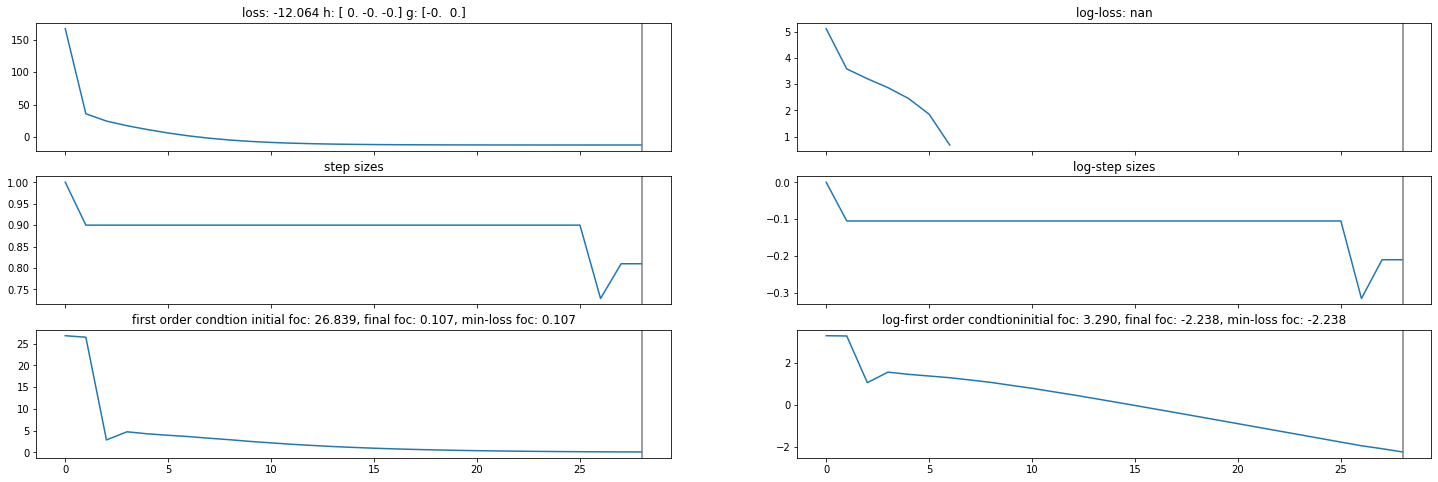

In [11]:
f = utils.plot_results(result)

In [20]:
pap = result['P']@L@result['P'].T
print(result['ext_data']['L'][-1].real,
np.linalg.eig(result['ext_data']['L'][-1])[0].real, 
np.sort(np.linalg.eig(pap)[0])[:6].real,
1.0 - ( np.count_nonzero(pap) / float(pap.size) ), 1.0 - ( np.count_nonzero(L) / float(L.size) ))

KeyError: 'ext_data'

In [14]:
voxel_id, voxel_bound = voxel_cluster(X_k_n, np.array([5, 5]))

/home/orange3xchicken/.local/lib/python3.7/site-packages/jax/_src/lax/lax.py:6271: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


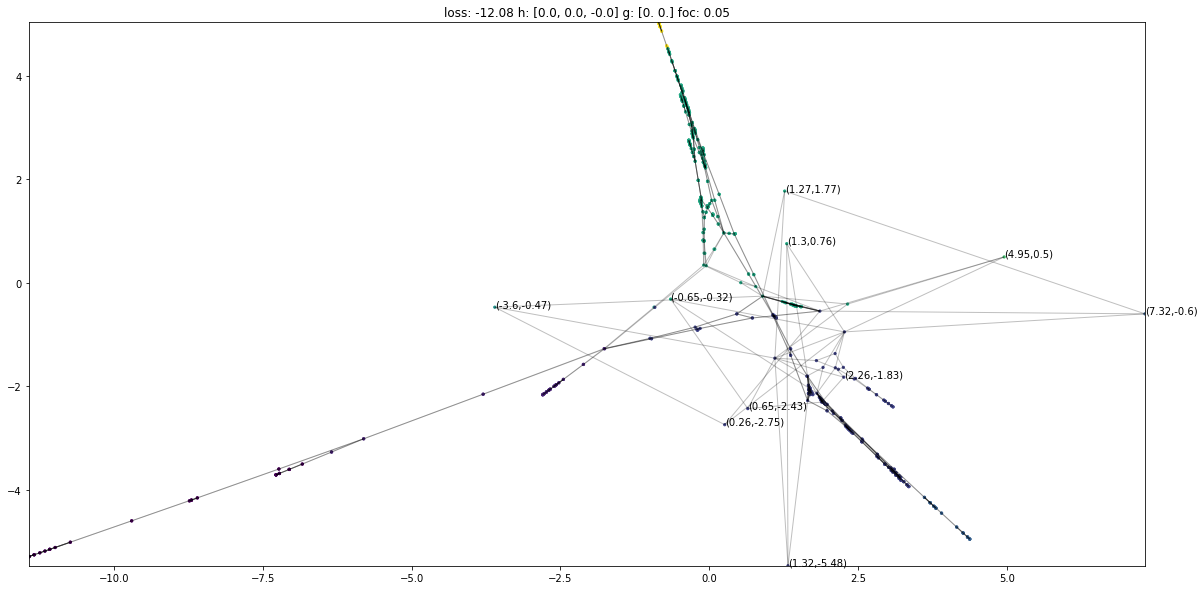

In [15]:
utils.plot_graph(X_k_n, graph, title='loss: {} h: {} g: {} foc: {}'.format(str(np.round(loss[-1],2)), [0.0,0.0,-0.0], np.round(gc,2), str(np.round(result['foc'][np.argmin(result['lossh'])],2))), fixed_indices=fixed_indices, c=voxel_id)
#utils.plot_graph(X_k_n, graph, title='loss: {} h: {} g: {} foc: {}'.format(str(np.round(loss[np.argmin(result['lossh'])],2)), np.round(hc,2), np.round(gc,2), str(np.round(result['foc'][np.argmin(result['lossh'])],2))), fixed_indices=fixed_indices, c=voxel_id)

In [ ]:
"""
WORK IN PROGRESS BELOW 
"""

In [ ]:
X_k = X_k_n
width = 10
size = np.array([width/2, width/2])

# levels
for _ in tqdm(range(2)): 
    size = size/2
    voxel_id, voxel2bound = voxel_cluster(X_k, size)
    unique_voxels, unique_vidx = np.unique(voxel_id, return_index=True)
    
    num_voxels_per_row = width/size[0]
    num_voxels=num_voxels_per_row**2
    
    for _ in range(5):
        np.random.shuffle(unique_vidx)
        
        for vidx in unique_vidx:
            vid = voxel_id[vidx]
            fixed_indices = (~clust_to_mask(voxel_id, vid).astype(bool)).astype(int)
            #fixed_indices = (~np.sum([clust_to_mask(voxel_id, vid), 
            #                          clust_to_mask(voxel_id, min(vid+1, num_voxels_per_row//(vid+1)*num_voxels_per_row))], axis=0).astype(bool)).astype(int) 
            #fixed_indices = (~np.sum([clust_to_mask(voxel_id, vid), 
            #                          clust_to_mask(voxel_id, min(vid+1, num_voxels_per_row//(vid+1)*num_voxels_per_row)),
            #                          clust_to_mask(voxel_id, min(vid+num_voxels_per_row, num_voxels)), 
            #                          clust_to_mask(voxel_id, min(vid+num_voxels_per_row+1, num_voxels))], axis=0).astype(bool)).astype(int) 

            if (1-fixed_indices).sum() < 4:
                continue

            num_move = (1-fixed_indices).sum()
            cc1 = num_move*size[0]**2*1/12
            cc2 = num_move*size[1]**2*1/12
            #cc1 = num_move*(2*size[0])**2*1/12
            #cc2 = num_move*(2*size[1])**2*1/12
            cc3 = 0

            C = jnp.block([[cc1, cc3],[cc3, cc2]])

            offset = (np.max(X_k,axis=0) - np.min(X_k,axis=0))/2
            centroid = voxel2bound[vidx]*size + size/2 - offset
            #centroid = jax.ops.index_add(centroid, 0, size[0]/2)
            #centroid = voxel2bound[vidx]*size - offset
            #centroid = np.mean(X_k[(1-fixed_indices)],axis=0)

            method = "pgd"
            if method == "pgd":
                opt_init, opt_update, get_params = padam(1e-2, partial(lambda x, y: project(y,x),C), 
                                                         b1=0.9, b2=0.999, eps=1e-08)
            elif method == "pnd":
                opt_init, opt_update, get_params = psgd(partial(lambda x, y: project(y,x),C))


            result = cluster(rng, (opt_init, opt_update, get_params), 
                             X_k, L, np.where(fixed_indices)[0], maxiters=1000, c1=cc1, c2=cc2, c3=0, centroid=centroid, 
                             centercons=num_move*centroid, v=None, D=None, eps=1e-8, 
                             convergence_criterion=1e-3, method=method)

            results.append(result)
            X_k = result['x']
            gc = result['g']
            hc = result['h']
            loss = result['lossh']
            #param_hist.extend(result['sln_path'])
            print('loss: {} h: {} g: {}'.format(str(np.round(loss[-1],2)), np.round(hc,2), np.round(gc,2)))   


In [ ]:
utils.plot_graph(X_k, graph, c=voxel_id,title=str(np.round(wl(X_k, A, A),3)))

In [ ]:
"""
Generate animation frames
"""

dir = './frames'
if os.path.exists(dir):
    shutil.rmtree(dir)
os.makedirs(dir)

plt.figure(figsize=(20,10))
ax = plt.axes()

for l, result in enumerate(results):
    param_hist = result['sln_path']
    idx = np.linspace(0, len(param_hist)-1, num=100,dtype=int)
    #P_x, P_y = result['P']
    P_tmp = result['P']
    P_x_tmp = P_tmp
    P_y_tmp = P_tmp
    n0_x_tmp, n0_y_tmp = result['n']
    for k in idx:
        X_k_tmp = param_hist[k]

        X_k_n_tmp = np.zeros((n0_x_tmp.shape[0],2))
        X_k_n_tmp[:,0] = np.array(P_x_tmp.T@X_k_tmp[:,0]) + n0_x_tmp.T
        X_k_n_tmp[:,1] = np.array(P_y_tmp.T@X_k_tmp[:,1]) + n0_y_tmp.T
        positions_tmp = X_k_n_tmp

        ax.clear()
        
        ax = utils.plot_graph(X_k_n_tmp, graph, c=voxel_id)
        
        plt.savefig('./frames/{}_{}.png'.format(l, k))
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [ ]:
"""
save animation as gif
"""
# filepaths
fp_in = "./frames/*.png"
fp_out = "./frames/animation.gif"

img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in),key=os.path.getmtime)]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=500, loop=0)

In [ ]:
_, unique_vidx = np.unique(voxel_id, return_index=True)
X_k = X_k_n
#opt_init, opt_update, get_params = padam(1e-1,partial(lambda x, y: project(y,x),C), b1=0.9, b2=0.999, eps=1e-08)
#opt_init, opt_update, get_params = padam(1e-1,lambda x: x, b1=0.9, b2=0.999, eps=1e-08)

for vidx in unique_vidx:
    vid = voxel_id[vidx]
    fixed_indices = (~clust_to_mask(voxel_id, vid).astype(bool)).astype(int)
    #if (1-fixed_indices).sum() < 100:
    #    continue
    
    num_move = (1-fixed_indices).sum()
    cc1 = num_move*size[0]**2*1/12
    cc2 = num_move*size[1]**2*1/12
    cc3 = 0
    
    C = jnp.block([[cc1, cc3],[cc3, cc2]])
        
    offset = (np.max(positions,axis=0) - np.min(positions,axis=0))/2
    centroid = voxel2bound[vidx]*size + size/2 - offset
    
    #opt_init, opt_update, get_params = padam(1e-4,partial(lambda x, y, z: project(z, x, y), C, centroid), 
    #                                         b1=0.9, b2=0.999, eps=1e-08)
    #opt_init, opt_update, get_params = padam(1e-2,lambda x : x, 
    #                                         b1=0.9, b2=0.999, eps=1e-08)
    opt_init, opt_update, get_params = psgd(partial(lambda x, y: project(y,x),C))


    result = cluster(rng, (opt_init, opt_update, get_params), 
                     X_k, L, np.where(fixed_indices)[0], maxiters=5000, c1=cc1, c2=cc2, c3=0, centroid=centroid, 
                     centercons=num_move*centroid, v=None, D=None, eps=1e-8)
    results.append(result)
    X_k = result['x']
    gc = result['g']
    hc = result['h']
    loss = result['lossh']
    #param_hist.extend(result['sln_path'])
    print('loss: {} h: {} g: {}'.format(str(np.round(loss[-1],2)), np.round(hc,2), np.round(gc,2)))    

In [ ]:
"""BFS"""
"""
def BFS(i, maxdepth, X_k, results):
    if i > maxdepth:
        return results
    size = np.array([10, 10])
    voxel_id, voxel2bound = voxel_cluster(X_k_n, size)
    _, unique_vidx = np.unique(voxel_id, return_index=True)
    
    for vidx in unique_vidx:
        vid = voxel_id[vidx]
        fixed_indices = (~clust_to_mask(voxel_id, vid).astype(bool)).astype(int)

        num_move = (1-fixed_indices).sum()
        cc1 = num_move*size[0]**2*1/12
        cc2 = num_move*size[1]**2*1/12
        cc3 = 0

        C = jnp.block([[cc1, cc3],[cc3, cc2]])

        offset = (np.max(positions,axis=0) - np.min(positions,axis=0))/2
        centroid = voxel2bound[vidx]*size + size/2 - offset

        result = cluster(rng, (opt_init, opt_update, get_params), 
                     X_k, L, np.where(fixed_indices)[0], maxiters=5000, c1=cc1, c2=cc2, c3=0, centroid=centroid, 
                     centercons=num_move*centroid, v=None, D=None, eps=1e-8)

        results.append(result)
        X_k = result['x']
        gc = result['g']
        hc = result['h']
        loss = result['lossh']

        print('loss: {} h: {} g: {}'.format(str(np.round(loss[-1],2)), np.round(hc,2), np.round(gc,2)))

        DFS(i+1, maxdepth, X_k, results)
"""